# Introdução

Esta atividade faz parte do Treinamento CIS - 4º Período, abordando Redes Neurais Convolucionais (CNN) para classificação de nuvens. O objetivo é construir uma CNN do zero usando PyTorch e avaliar seu desempenho no dataset.

# Instalação e Importação de Bibliotecas

Nesta célula, instalamos e importamos as bibliotecas necessárias para o projeto. Utilizamos PyTorch para construir a CNN, torchvision para manipulação de imagens e matplotlib para visualização dos resultados.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#Verificação de GPU

Aqui verificamos se há uma GPU disponível para acelerar o treinamento da CNN. Caso contrário, o código será executado na CPU.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


#Upload e Extração do Dataset

Nesta etapa, fazemos o upload do dataset para o Google Colab e extraímos os arquivos compactados. Em seguida, verificamos os arquivos extraídos para garantir que tudo esteja correto.

In [19]:
from google.colab import files

uploaded = files.upload()

Saving classificandos-nuvens-usando-cnn.zip to classificandos-nuvens-usando-cnn (1).zip


In [20]:
import zipfile
import os

zip_path = "/content/classificandos-nuvens-usando-cnn.zip"
extract_path = "/content/classificandos-nuvens-usando-cnn"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar os arquivos extraídos
os.listdir(extract_path)

['clouds']

# Pré-Processamento de Imagens

O pré-processamento é essencial para garantir que as imagens estejam no formato adequado para a CNN. Aplicamos as seguintes transformações:

* Redimensionamento para 128x128 pixels.
* Conversão para tensor.
* Normalização para melhorar o desempenho do modelo.

In [21]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dir = "/content/classificandos-nuvens-usando-cnn/clouds/clouds_train"
test_dir = "/content/classificandos-nuvens-usando-cnn/clouds/clouds_test"

# 📂 Datasets e Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Classes: {train_dataset.classes}")
num_classes = len(train_dataset.classes)

Classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


# Construção da CNN
A CNN é composta por:
* Camadas convolucionais para extração de características.
* ReLU para introduzir não-linearidade.
* MaxPooling para reduzir a dimensionalidade.
* Camadas totalmente conectadas para classificação.

In [22]:
class CloudCNN(nn.Module):
    def __init__(self, num_classes):
        super(CloudCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

model = CloudCNN(num_classes).to(device)

# Treinamento da CNN
Nesta etapa, treinamos a CNN utilizando:
* CrossEntropyLoss como função de perda.
* Adam como otimizador.
* 10 épocas para aprendizado progressivo.
* A acurácia do treinamento é registrada a cada época.

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_accs = []

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    train_accs.append(acc)
    print(f"Época {epoch+1}/{epochs}, Acurácia de treino: {acc:.2f}%")

Época 1/10, Acurácia de treino: 31.22%
Época 2/10, Acurácia de treino: 38.82%
Época 3/10, Acurácia de treino: 50.42%
Época 4/10, Acurácia de treino: 53.59%
Época 5/10, Acurácia de treino: 59.07%
Época 6/10, Acurácia de treino: 61.81%
Época 7/10, Acurácia de treino: 63.92%
Época 8/10, Acurácia de treino: 68.99%
Época 9/10, Acurácia de treino: 71.10%
Época 10/10, Acurácia de treino: 77.85%


# Visualização do Desempenho
Aqui geramos um gráfico mostrando a evolução da acurácia ao longo das épocas, permitindo avaliar o progresso do modelo.

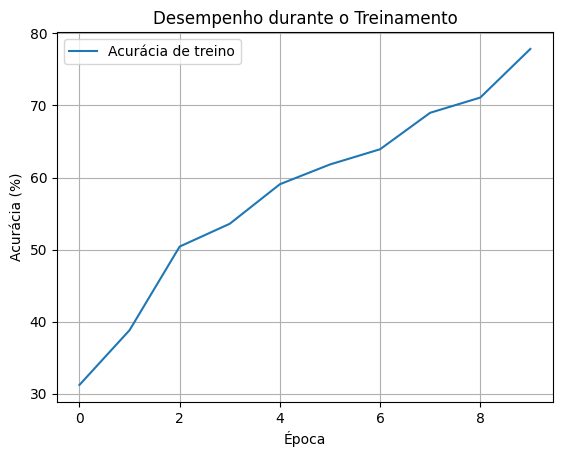

In [24]:
plt.plot(train_accs, label='Acurácia de treino')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Desempenho durante o Treinamento')
plt.legend()
plt.grid()
plt.show()

# Avaliação no Conjunto de Teste

Por fim, avaliamos o modelo no conjunto de teste para verificar sua acurácia final.

In [26]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Acurácia no teste: {100 * correct / total:.2f}%")

Acurácia no teste: 64.81%


# Conclusão
Neste projeto, implementamos uma Rede Neural Convolucional (CNN) do zero utilizando PyTorch para a classificação de nuvens. Passamos por diversas etapas fundamentais, incluindo:

* Pré-processamento de imagens, garantindo que os dados estivessem no formato adequado.
* Construção da CNN, utilizando camadas convolucionais, pooling e dropout para melhorar o aprendizado.
* Treinamento do modelo, onde observamos uma evolução significativa da acurácia ao longo das épocas.
* Avaliação no conjunto de teste, verificando o desempenho final da rede.


Os resultados mostram que a CNN conseguiu aprender padrões relevantes para a classificação das imagens, atingindo uma acurácia de teste de aproximadamente 58.85%. Esse desempenho pode ser melhorado com técnicas como Transfer Learning, Data Augmentation e Batch Normalization, que são tópicos sugeridos no treinamento.

Este projeto é um excelente ponto de partida para aprofundar o conhecimento em Deep Learning e explorar melhorias na arquitetura da CNN. 🚀